# Boundary layer in transition to turbulence

In [1]:
import numpy as np
from numpy.random import randint
import h5py
import matplotlib.pyplot as plt
import sys
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
from scipy.io import loadmat
from scipy import sparse, linalg
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint
from scipy.interpolate import interp1d


# adding Tools to the system path
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import blasius_solution as bs


import matplotlib as mpl

mpl.rc("text", usetex=True)
mpl.rc("font", family="serif")
mpl.rc("figure", figsize=(15, 3))
mpl.rc("xtick", labelsize=14)
mpl.rc("ytick", labelsize=14)
mpl.rc("axes", labelsize=20)
mpl.rc("axes", titlesize=20)
%config InlineBackend.figure_format = 'retina'


from matplotlib.colors import ListedColormap

# Seaborn colormap
import seaborn as sns

sns_list = sns.color_palette("deep").as_hex()
sns_list.insert(0, "#ffffff")
sns_cmap = ListedColormap(sns_list)

cm = sns_cmap

mpl_colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

In [2]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [3]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u = np.array(file["um"])
v = np.array(file["vm"])
p = np.array(file["pm"])
Ruu = np.array(file["uum"]) - u**2
Ruv = np.array(file["uvm"]) - u * v
Rvv = np.array(file["uvm"]) - v**2

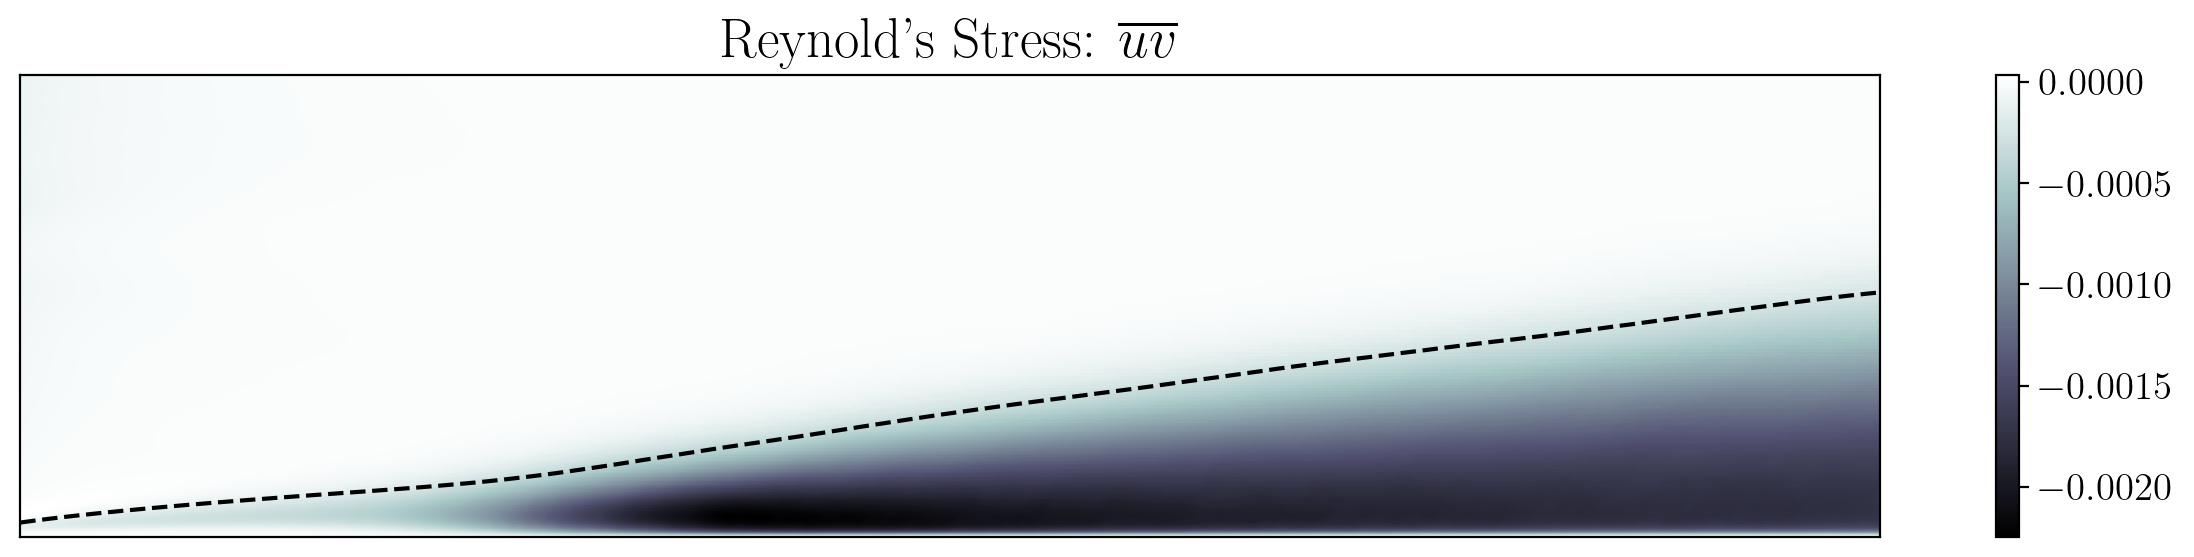

In [4]:
# Visualize by wall-normal Reynolds stress

X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1
nu = 1 / 800
Re = (U_inf / nu) * x

pf.plot_reynolds_stress(x, y, X, Y, u, Ruv)

## Get the finite difference derivatives to estimate the gradients

In [5]:
# Get space steps

dx = x[1] - x[0]
dy = y[1:] - y[:-1]

nx = len(x)  # Number of points in x
ny = len(y)  # Number of points in y

Dy = sparse.diags([-1, 1], [-1, 1], shape=(ny, ny)).toarray()

# Get 2nd order forward/backwards at the boundaries
Dy[0, :3] = np.array([-3, 4, -1])
Dy[-1, -3:] = np.array([1, -4, 3])

for i in range(ny - 1):
    Dy[i, :] = Dy[i, :] / (2 * dy[i])
Dy[-1, :] = Dy[-1, :] / (2 * dy[-1])

# Repeat this for the x-direction
Dy = sparse.block_diag([Dy for i in range(nx)])  # Creates a block diagonal matrix
# with the Dy matrix on the diagonal

Dx = sparse.diags([-1, 1], [-ny, ny], shape=(nx * ny, nx * ny))
Dx = sparse.lil_matrix(Dx)

# Get 2nd order forwards/backwards with boundary conditions
for i in range(ny):
    Dx[i, i] = -3
    Dx[i, ny + i] = 4
    Dx[i, 2 * ny + i] = -1
    Dx[-(i + 1), -(i + 1)] = 3
    Dx[-(i + 1), -(ny + i + 1)] = -4
    Dx[-(i + 1), -(2 * ny + i + 1)] = 1
Dx = Dx / (2 * dx)

Dx = sparse.csr_matrix(Dx)
Dy = sparse.csr_matrix(Dy)

Dxx = 2 * (Dx @ Dx)
Dyy = 2 * (Dy @ Dy)

In [6]:
# Flatten arrays for matrix multiplication, using fortran ordering
u = u.flatten("F")
v = v.flatten("F")
p = p.flatten("F")
Ruu = Ruu.flatten("F")
Ruv = Ruv.flatten("F")

# Get derivatives
ux = Dx @ u
uy = Dy @ u
vx = Dx @ v
vy = Dy @ v
px = Dx @ p
py = Dy @ p
lap_u = (Dxx + Dyy) @ u
Ruux = Dx @ Ruu
Ruvy = Dy @ Ruv

## Equation space representation

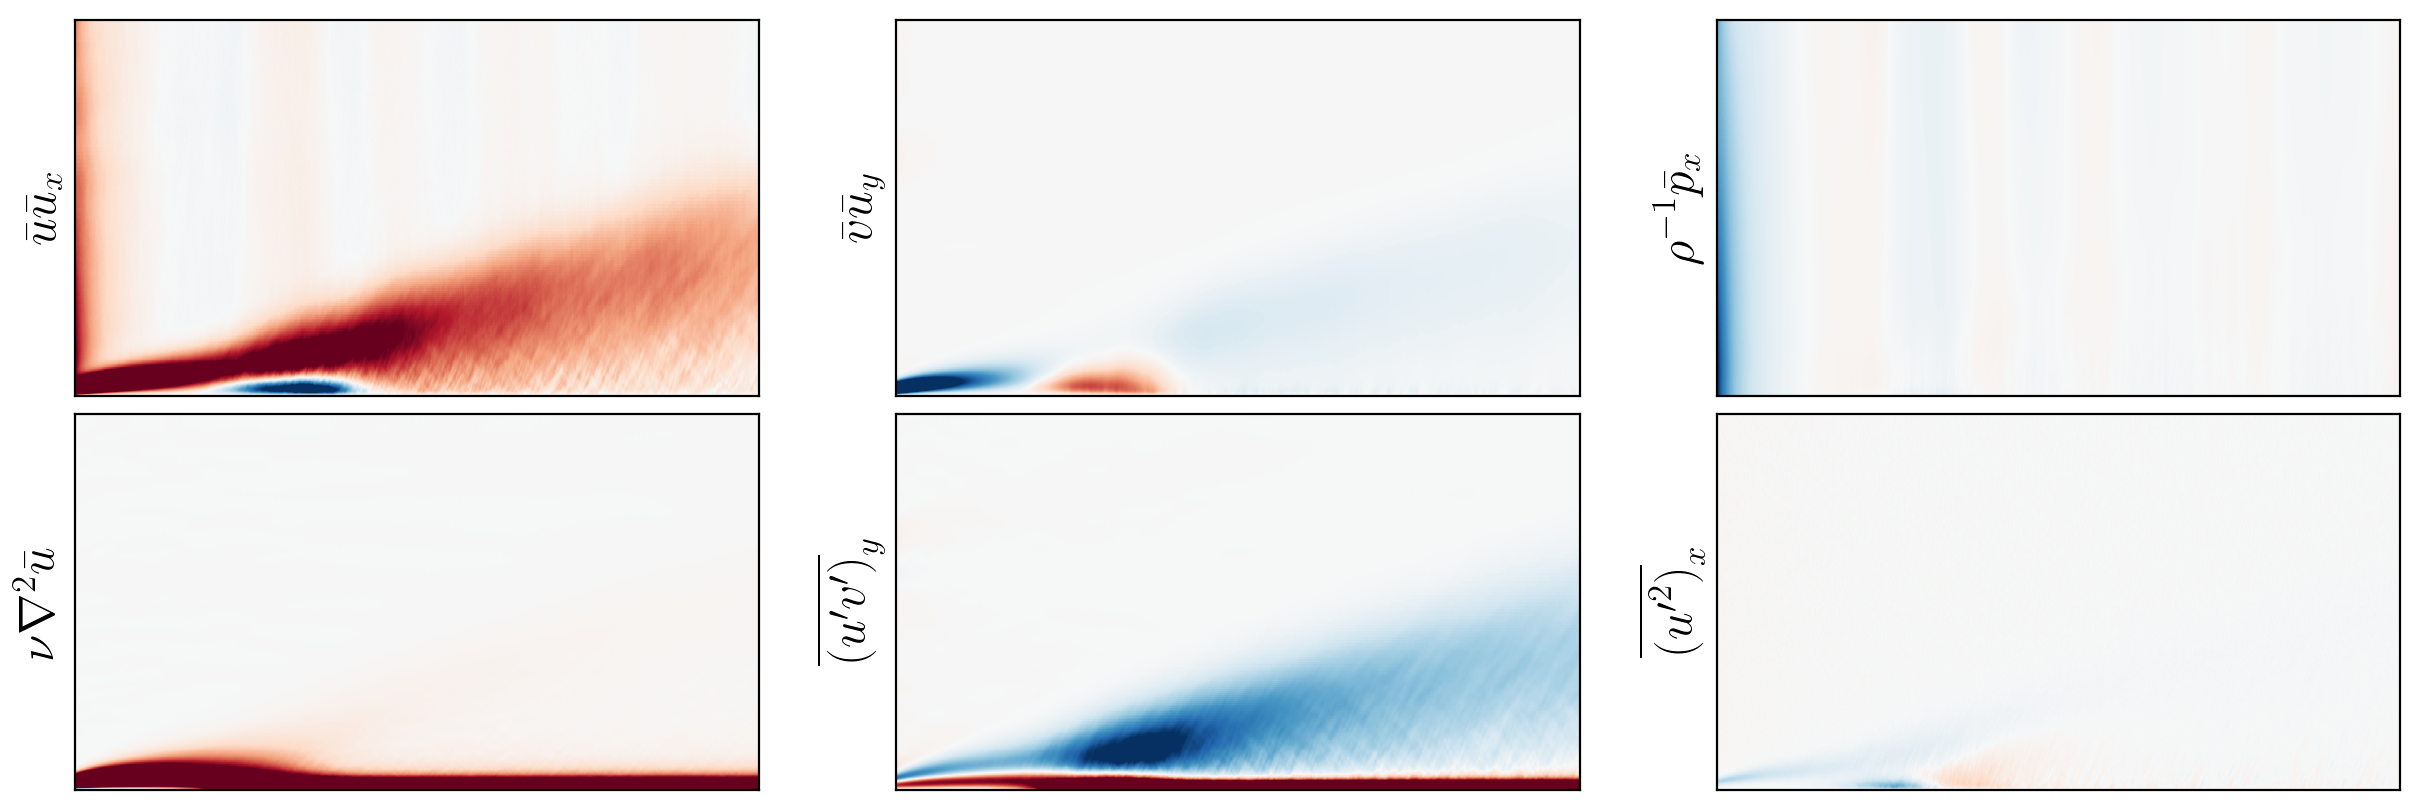

In [7]:
# Plot all six terms in the RANS equation
pf.plot_equation_space_bound_lay(x, y, nx, ny, u, ux, uy, v, Ruvy, Ruux, px, nu, lap_u)

## Cluster using Gaussian Mixture Model (GMM)

In [8]:
# Train Gaussian mixture model

# Gather the terms into an array of features
features = 1e3 * np.vstack([u * ux, v * uy, px, nu * lap_u, Ruvy, Ruux]).T
nfeatures = features.shape[1]

# Fit Gaussian mixture model
nc = 6  # Number of clusters, i.e. number of terms in the RANS equation
seed = np.random.randint(2**32)
seed = 3696299933  #  Set a seed for debugging/plotting
model = GaussianMixture(n_components=nc, random_state=seed)

# Train on only a subset (10%) of the data
sample_pct = 0.1
mask = np.random.permutation(features.shape[0])[: int(sample_pct * features.shape[0])]
model.fit(features[mask, :])

GaussianMixture(n_components=6, random_state=3696299933)

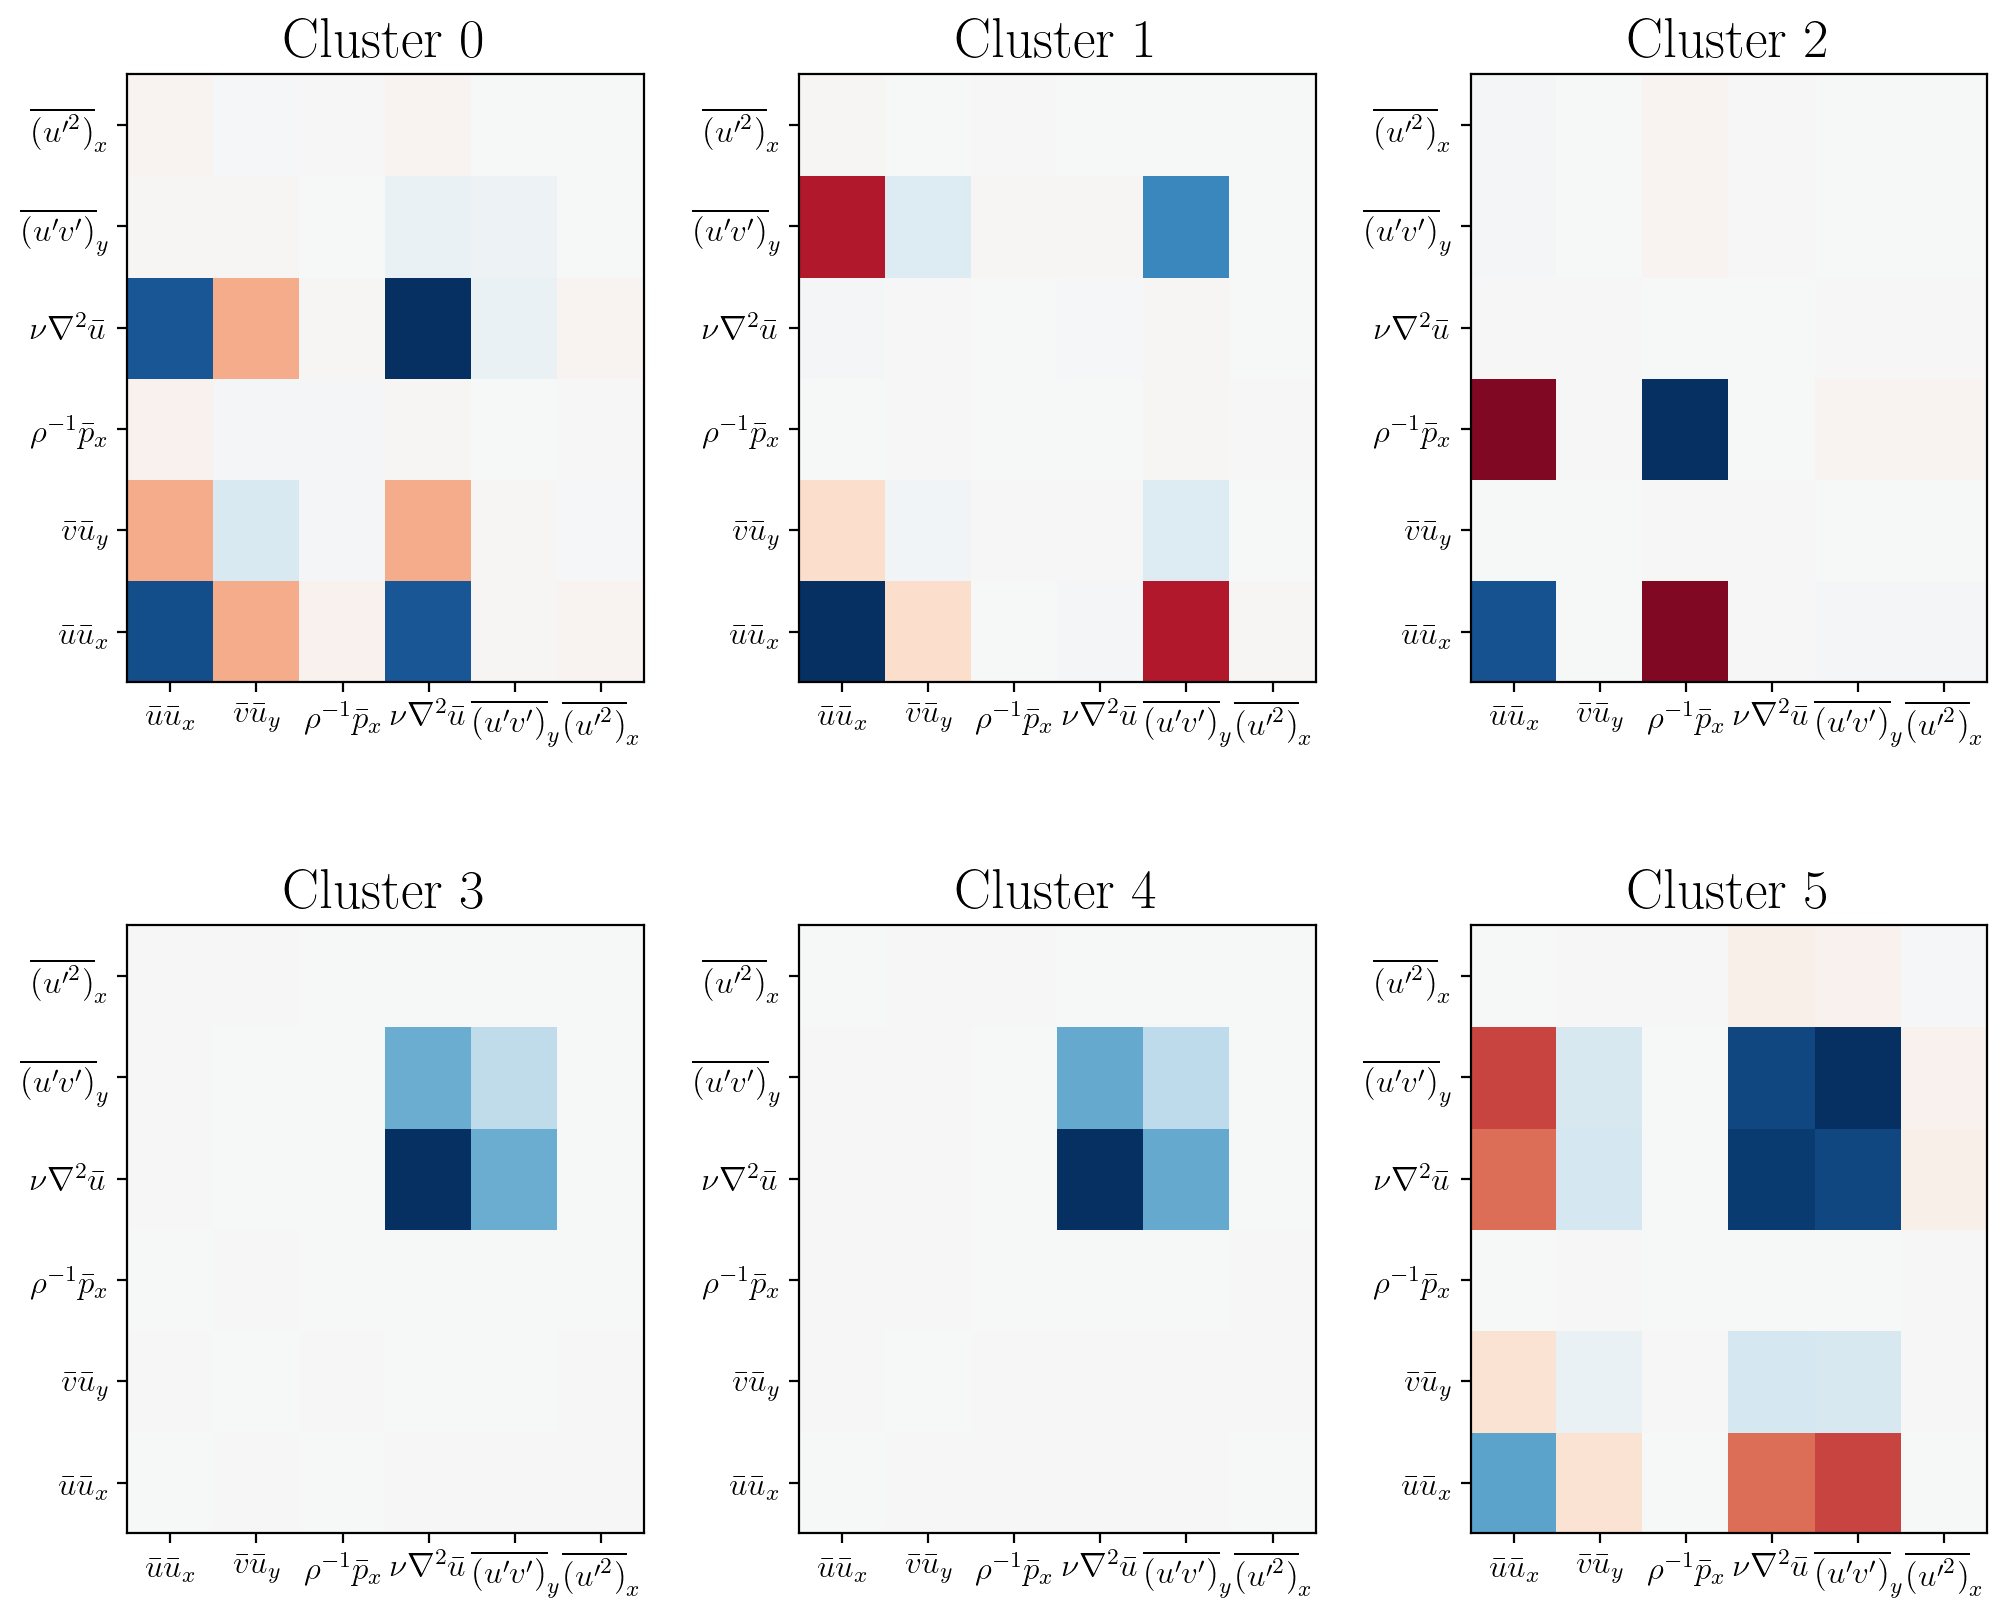

In [9]:
# Plot covariance matrices for the GMM
pf.plot_cov_mat(model, nfeatures, nc)

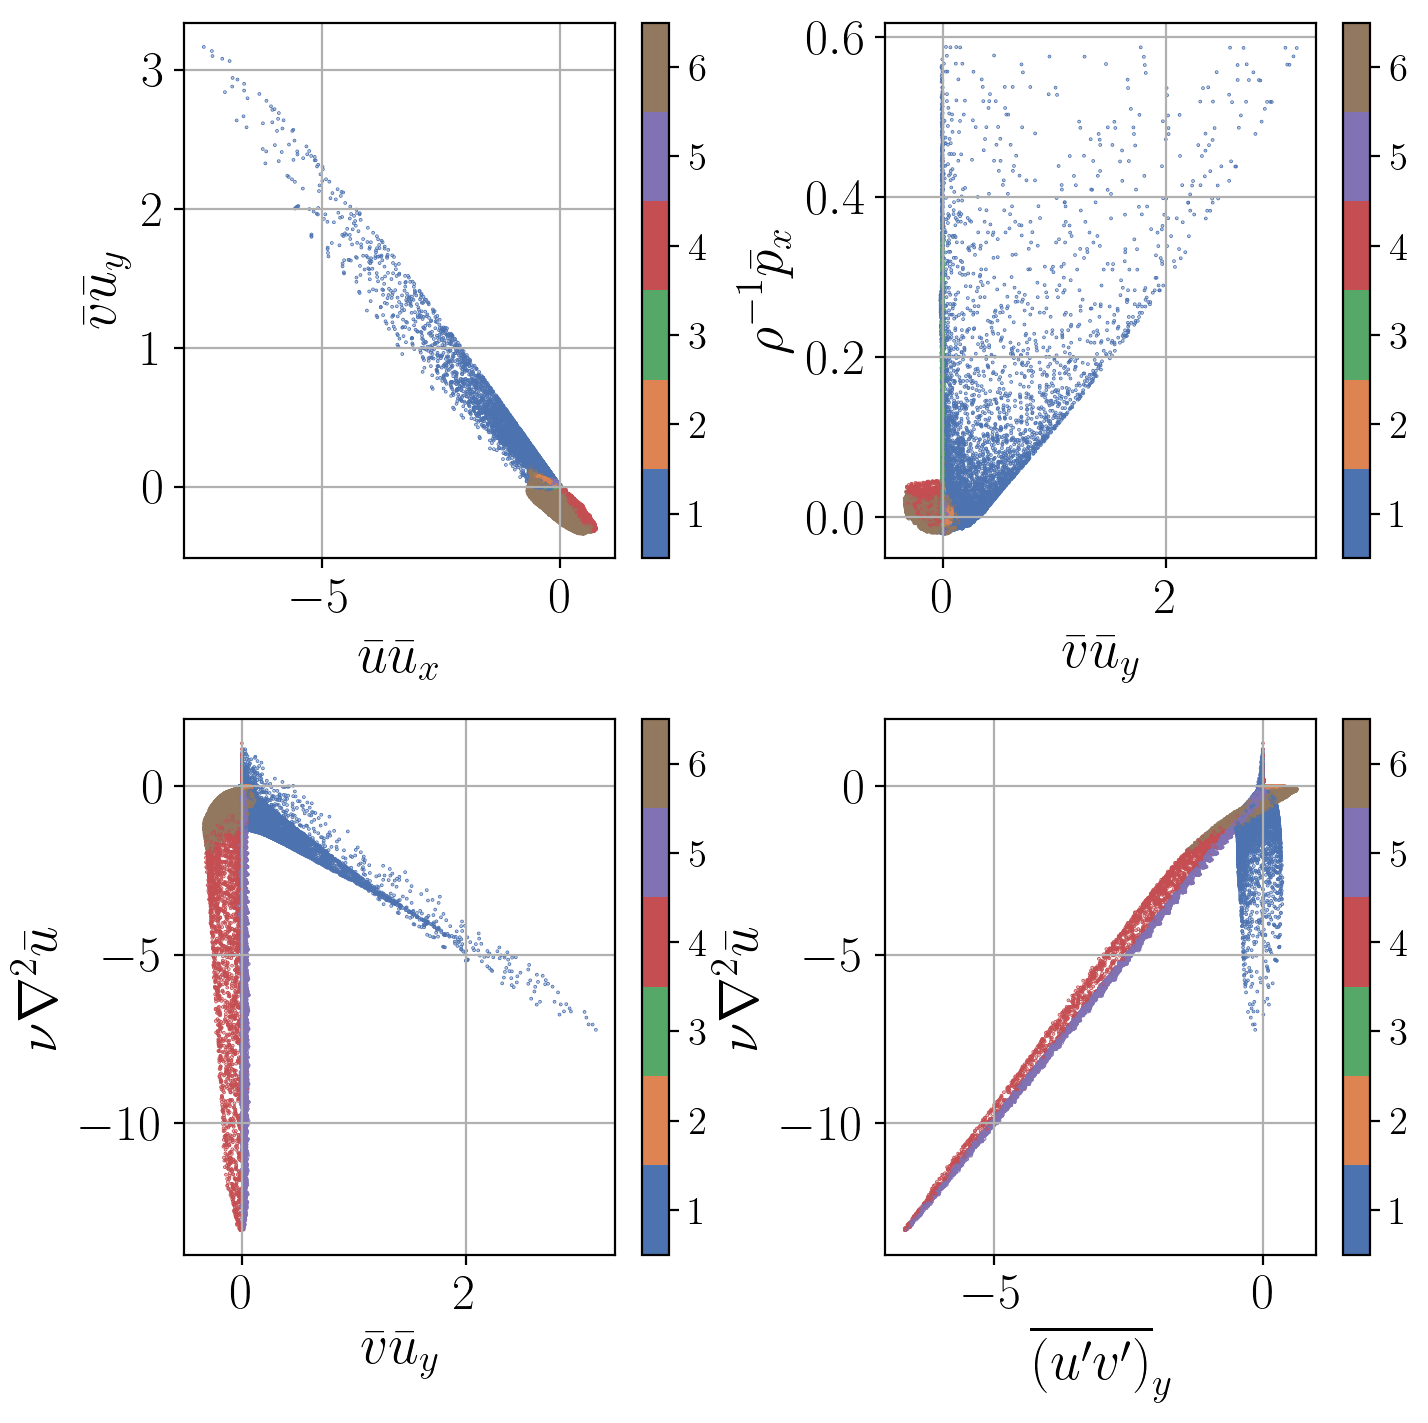

In [10]:
# Visualize GMM clustering with 2D views of equation space

cluster_idx = model.predict(features[mask, :]) + 1
clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nc + 1.5)

pf.plot_clustering_2d_eq_space(features, cluster_idx, mask, nc)

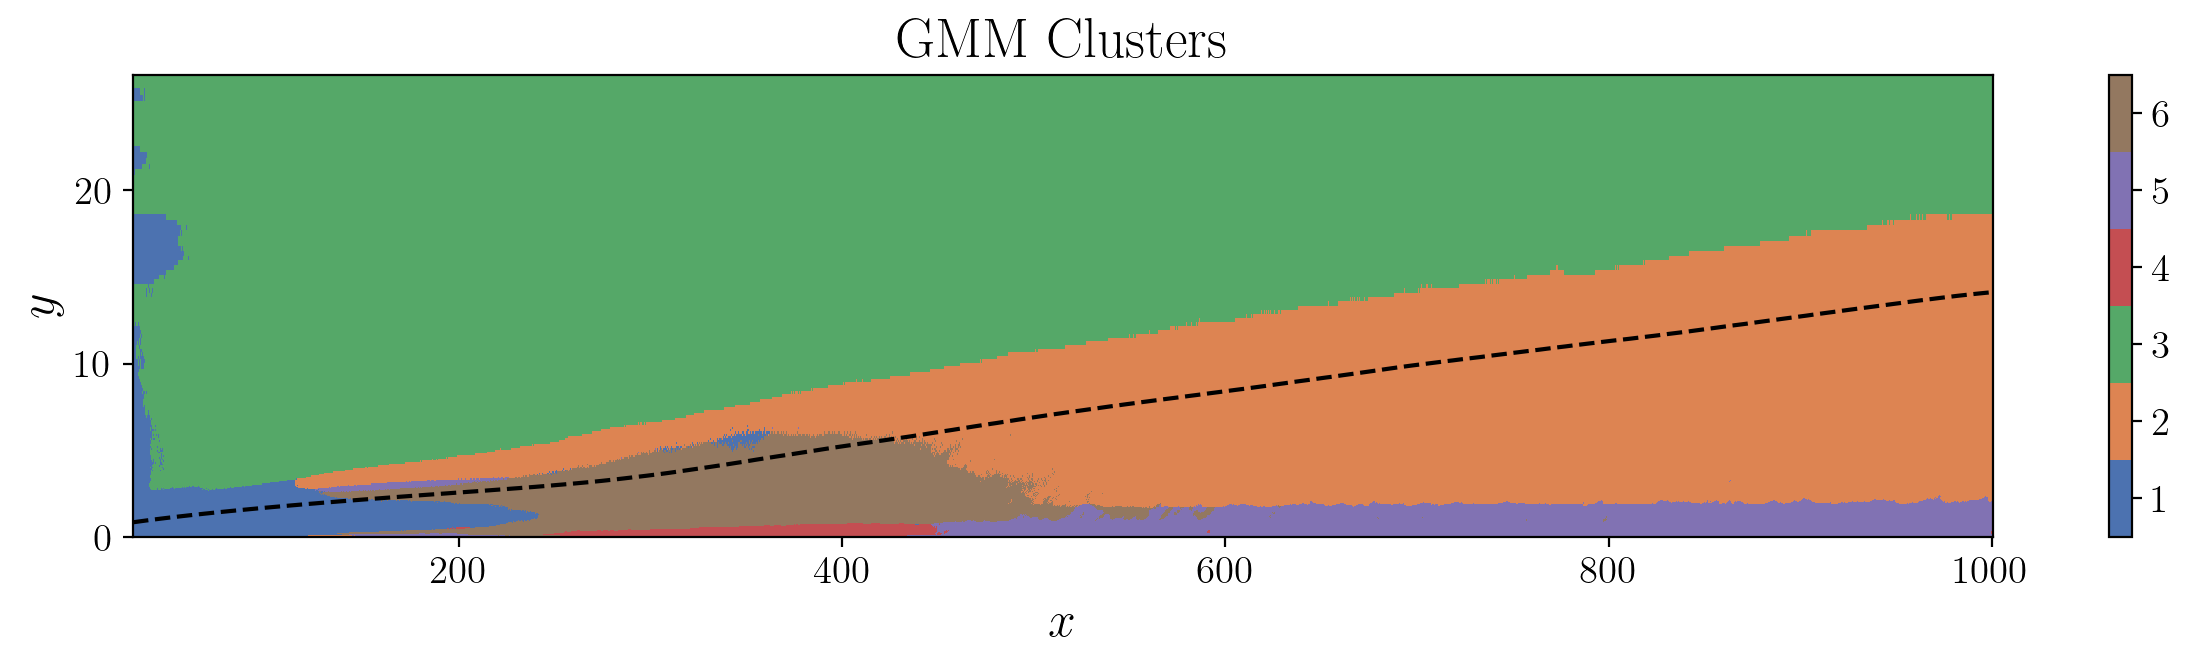

In [11]:
# "Predict" clusters in entire domain
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, [ny, nx], order="F")

# Colormap of clusters in entire domain
pf.plot_clustering_space(clustermap, x, y, X, Y, nx, ny, nc, u, U_inf)

## Sparce Principal Component Analysis (SPCA) dimensionality reduction

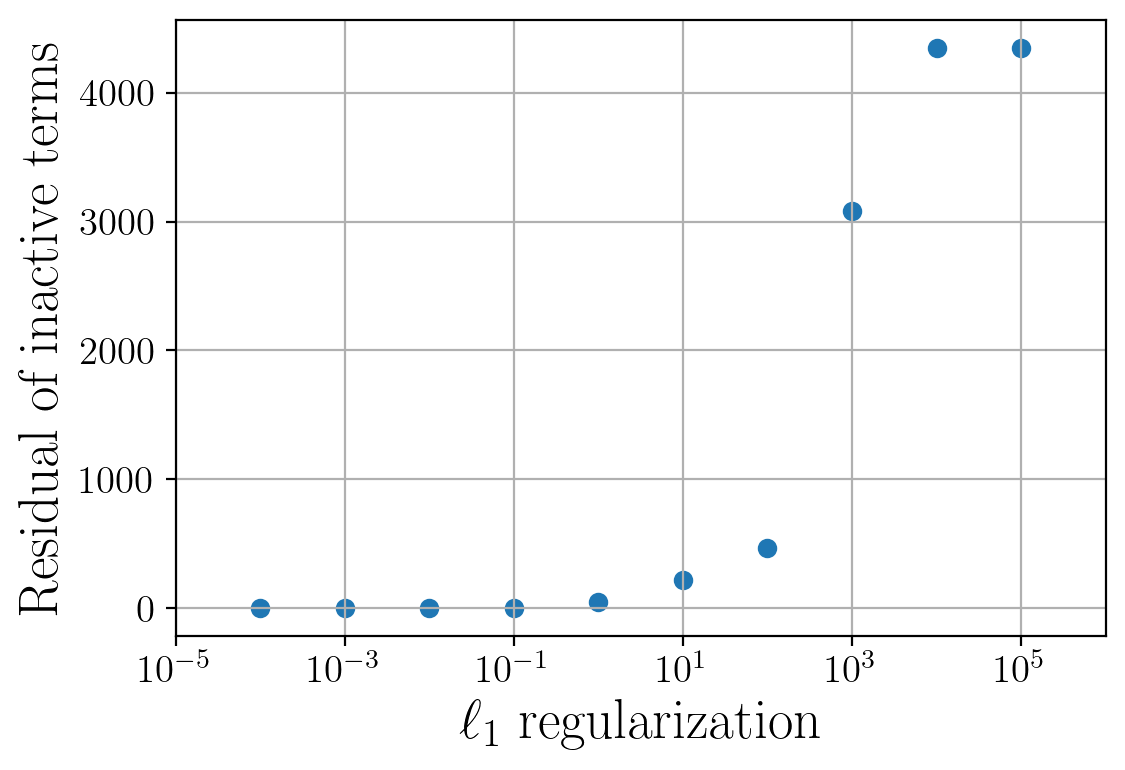

In [12]:
# Sparse PCA to identify directions of nonzero variance
# First step: model selection for L1 regularization
alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]
        spca = SparsePCA(n_components=1, alpha=alphas[k])  # normalize_components=True
        spca.fit(cluster_features)
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms]

        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])

pf.plot_spca_residuals(alphas, err)

In [13]:
# Sparse PCA to identify directions of nonzero variance
alpha_opt = 10

# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]
    spca = SparsePCA(n_components=1, alpha=alpha_opt)  # normalize_components=True
    spca.fit(cluster_features)
    print("GMM Cluster {0}:".format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else:
        print("None")

GMM Cluster 0:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$']
GMM Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 2:
['$\\bar{u} \\bar{u}_x$', '$\\rho^{-1} \\bar{p}_x$']
GMM Cluster 3:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 4:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 5:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']


## Resulting Final Dominant Balance Models

In [14]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

# Print balance models
for i in range(nmodels):
    print("SPCA Cluster {0}:".format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
    else:
        print("No dynamics")

# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

[[0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1. 0.]]
SPCA Cluster 0:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 2:
['$\\bar{u} \\bar{u}_x$', '$\\rho^{-1} \\bar{p}_x$']
SPCA Cluster 3:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$']
SPCA Cluster 4:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']


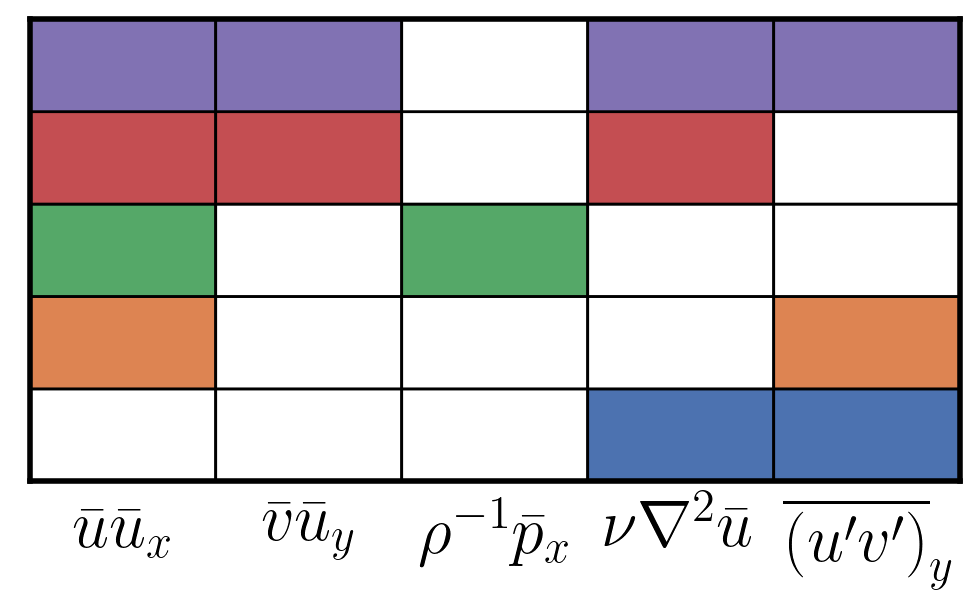

In [15]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap == 0
gridmap = (
    gridmap.T * np.arange(nmodels)
).T + 1  # Scale map so that active terms can be color-coded
gridmap[gridmask] = 0

# Delete zero terms
grid_mask = np.nonzero(np.all(gridmap == 0, axis=0))[0]
gridmap = np.delete(gridmap, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)

pf.plot_balance_models(gridmap, grid_labels)

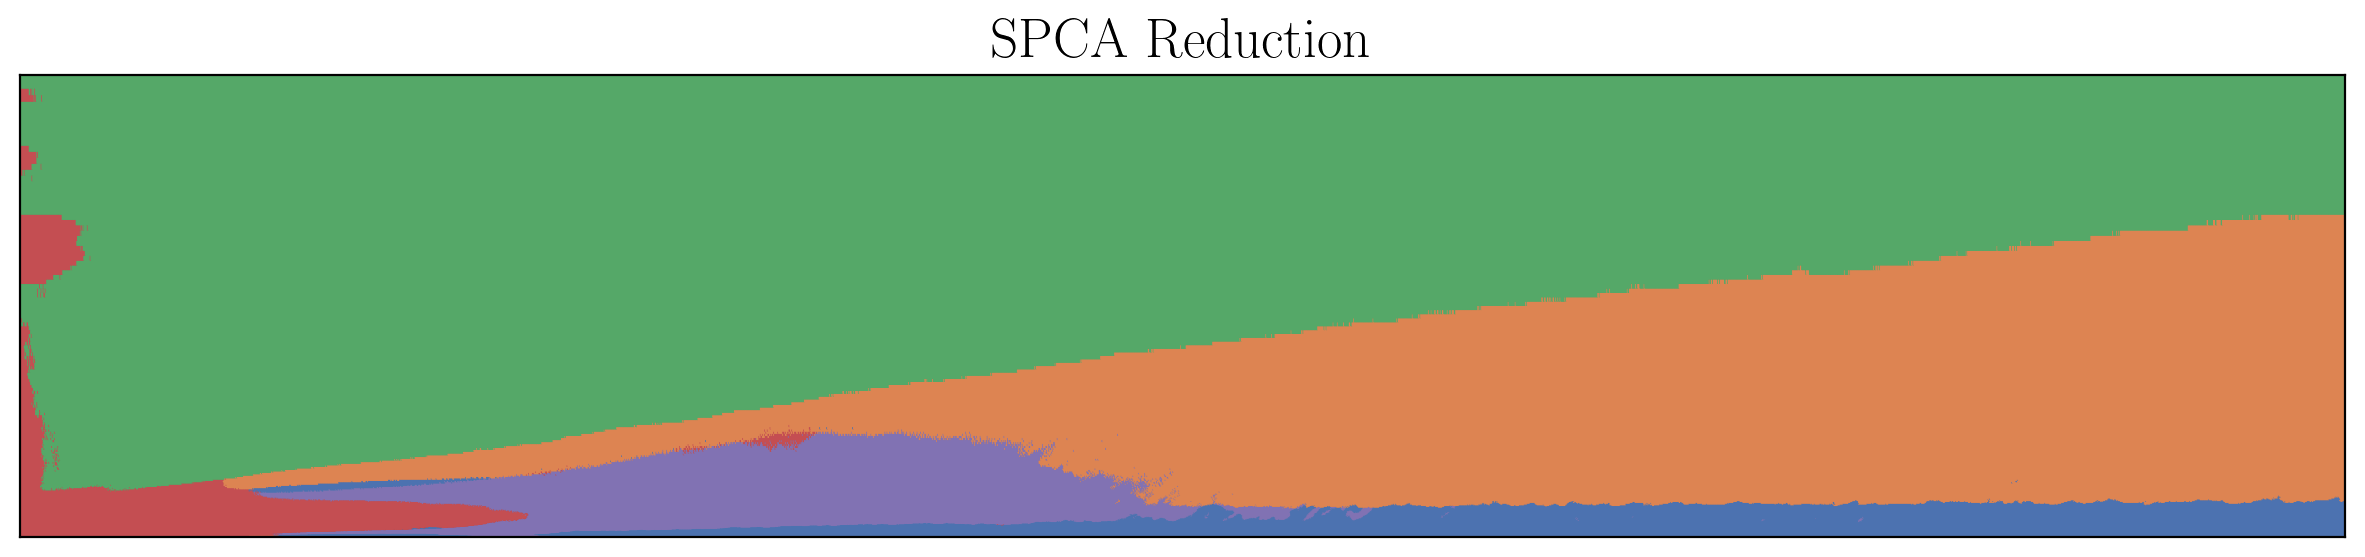

In [16]:
pf.plot_spca_reduced_clustering(x, y, balancemap, cm)

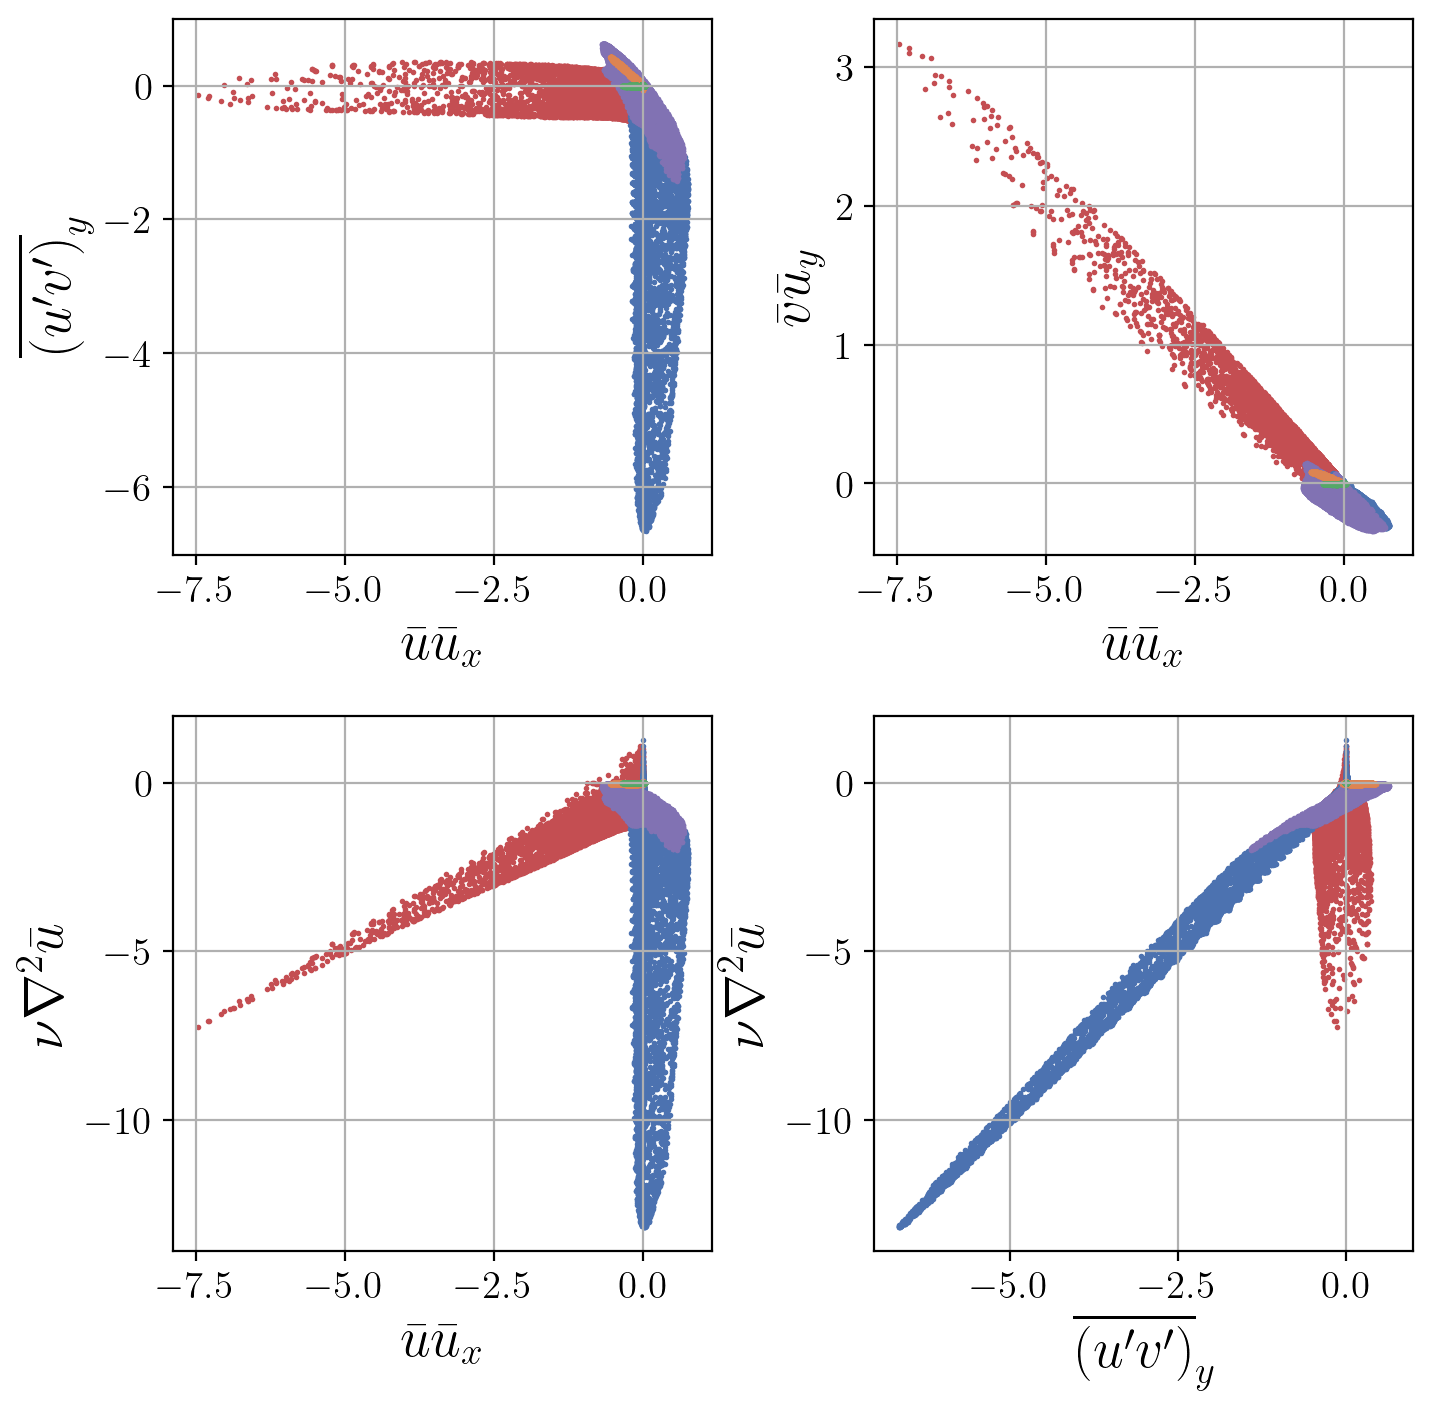

In [17]:
# Plot for figure 1

clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nmodels + 1.5)
fontsize = 20
s = 1

# Plot order for best visibility
order = [3, 0, 4, 1, 2]

# 2D views of feature space
pf.plot_feature_space(features, mask, balance_idx, order, labels, fontsize, s)

## Outer Layer Scaling

[0.0678363  0.81367304]


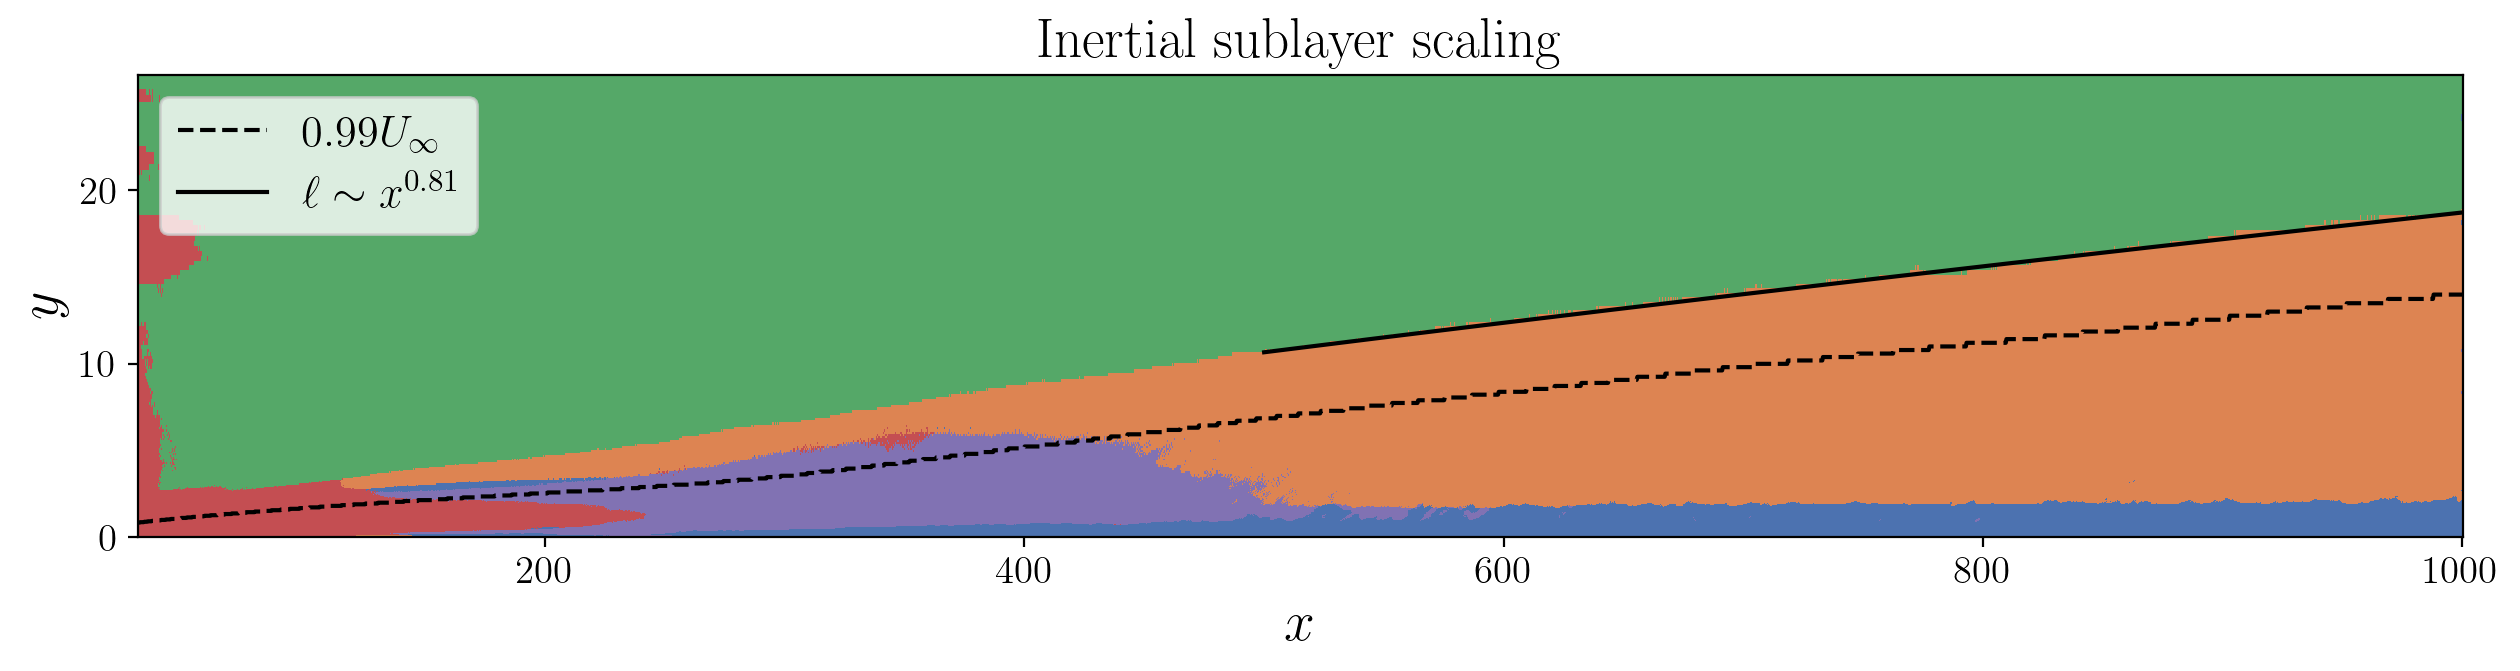

In [18]:
balancemap = np.reshape(balance_idx, (ny, nx), order="F")
u_map = np.reshape(u, (ny, nx), order="F")

x_min = 110  # Where inertial balance begins
x_turb = 500  # Where transitional region ends

x_idx = np.nonzero(x > x_min)[0]
x_layer = x[x_idx]

# First, find upper extent of inertial sublayer
y_gmm = np.zeros(len(x_idx))  # Upper extent of inertial balance
for i in range(len(x_idx)):
    # Loop through wall-normal direction until the balance changes
    j = len(y) - 1
    while balancemap[j, x_idx[i]] == 2:
        j -= 1
    y_gmm[i] = y[j]  # Store upper value of inertial balance

delta = np.zeros(len(x))  # 99% freestream contour
for i in range(len(x)):
    # Loop until velocity falls past 99% freestream
    j = 0
    while u_map[j, i] < 0.99:
        j += 1
    delta[i] = y[j - 1]

# Fit inertial balance to power law
power_law = lambda x, a, b: a * x**b

to_fit = x_layer > x_turb  # When transitional region ends
p_gmm, cov = curve_fit(power_law, x_layer[to_fit], y_gmm[to_fit])
gmm_fit = power_law(x_layer, *p_gmm)
print(p_gmm)

pf.plot_sublayer_scaling(x, y, balancemap, delta, x_layer, gmm_fit, p_gmm, to_fit)

## Self-similarity

67.12890296841488
70.31530942483438
67.11702949980734
72.55778692807048
71.41799991419018


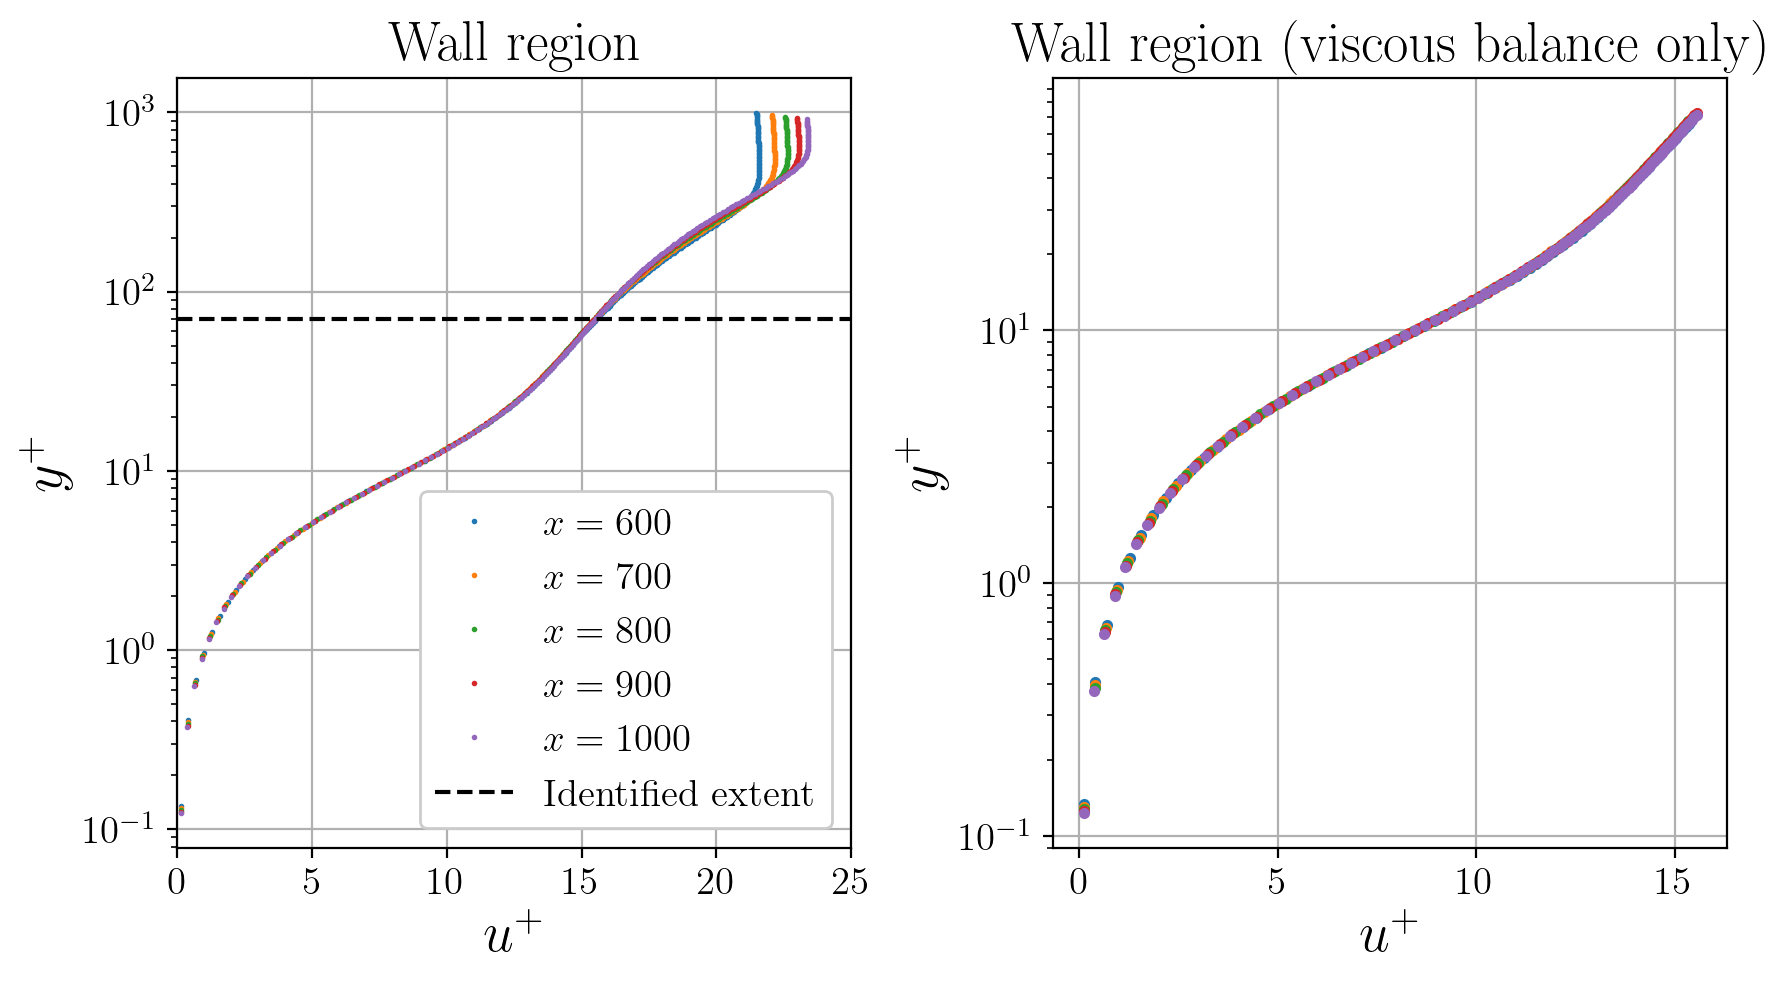

In [19]:
# Compute friction velocity with an estimate of wall shear stress
u_tau = np.sqrt(nu * uy[::ny])

y_plus = np.outer(y, u_tau / nu)
u_plus = np.reshape(u, [ny, nx], order="F") / u_tau

pf.plot_self_similarity(x, y_plus, u_plus, balancemap)

## Blasius solution in laminar regime

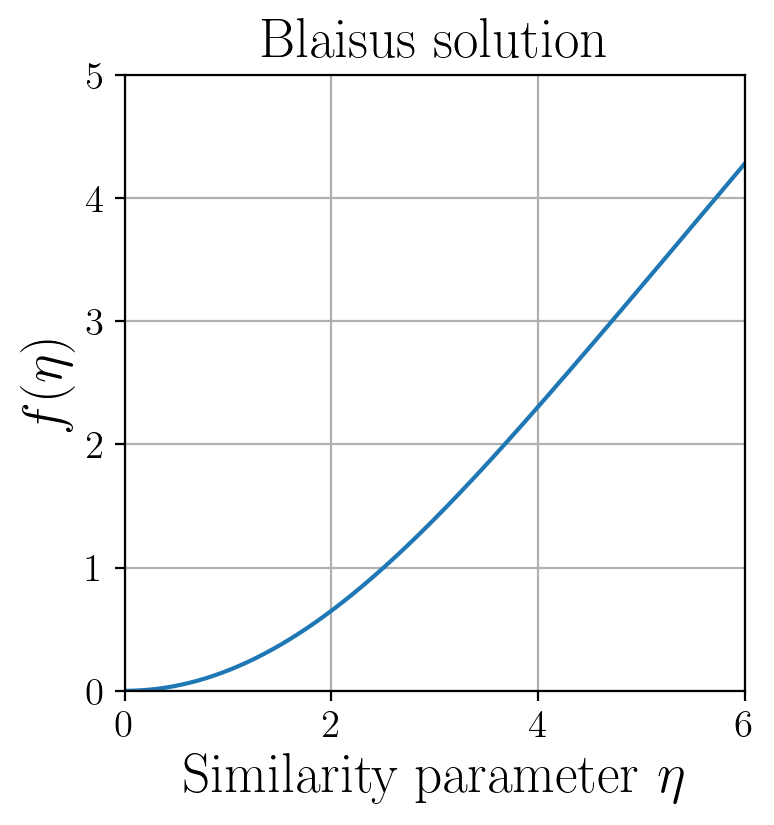

In [ ]:
# Solve Blasius equations numerically

eta_inf = 200
# Arbitrary "infinite" upper limit for domain
d_eta = 0.01
# Step size
eta = np.arange(0, eta_inf, d_eta)

F_init = [0, 0, 0]  # Initial guess for unknown initial condition


# Solve root-finding problem for unknown initial condition
opt_res = root(bs.bc_fn, F_init, tol=1e-4)
F0 = [0, 0, opt_res.x[2]]

# Evaluate with resulting initial conditions
f = odeint(lambda y, t: bs.blasius_rhs(y), F0, eta)

pf.plot_blasius_solution(eta, f)

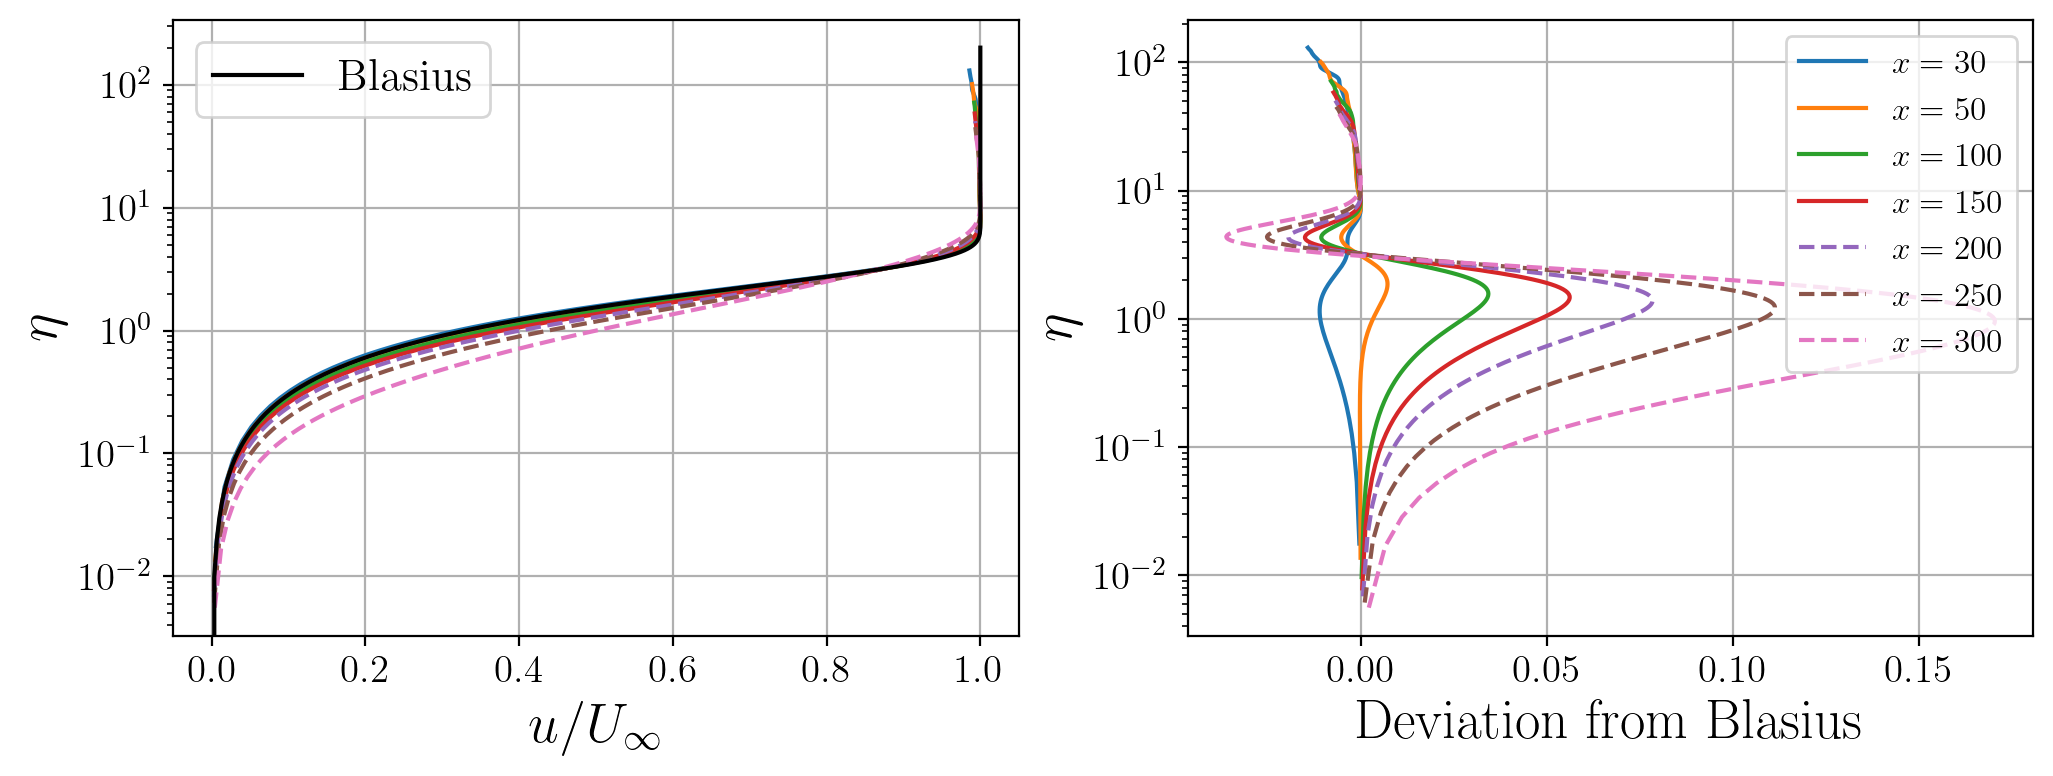

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
u_map = np.reshape(u, [ny, nx], order="F")

# Create a function of eta for f_prime
f_prime = interp1d(eta, f[:, 1])  # Second variable from first-order integrator

for x_plt in [30, 50, 100, 150, 200, 250, 300]:
    x_idx = np.nonzero(x > x_plt)[0][0]

    eta_plot = y * np.sqrt(U_inf / (1.1 * nu * x_plt))

    dev = u_map[:, x_idx] / max(u_map[:, x_idx]) - f_prime(eta_plot)
    if x_plt < 200:
        ax1.plot(u_map[:, x_idx] / max(u_map[:, x_idx]), eta_plot)
        ax2.plot(dev, eta_plot, label="$x={{{0}}}$".format(x_plt))
    else:
        ax1.plot(u_map[:, x_idx] / max(u_map[:, x_idx]), eta_plot, "--")
        ax2.plot(dev, eta_plot, "--", label="$x={{{0}}}$".format(x_plt))

# plt.ylim([0, 10])
ax1.plot(f[:, 1], eta, "k", label="Blasius")
ax1.set_yscale("log")
ax1.legend(fontsize=16)

ax1.set_ylabel("$\eta$")
ax1.set_xlabel("$u/U_\infty$")
ax1.grid()


ax2.legend(fontsize=12)
ax2.set_yscale("log")

ax2.set_ylabel("$\eta$")
ax2.set_xlabel("Deviation from Blasius")
ax2.grid()

plt.show()